### Import libraries

In [1]:
import sys
import os
import gc
import warnings
from functools import partial
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [3]:
from DataSetUp import *
from NNCarPrice import *
%load_ext autoreload
%autoreload 2

In [4]:
NNCarPrice.set_gpu_limit(6)

### Import data for regular NN without categorical embedding and split into train,dev, and test

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_onehot_data.csv")
features,y = data.drop("price",axis=1), data.price

In [6]:
data_setup = DataSetUp(features,y)

In [7]:
X_train,X_dev,X_test,y_train,y_dev,y_test = data_setup.data_split(2020,0.1,dev_set=True,dev_seed=1988,dev_size=0.11)

In [25]:
X_train.shape,X_dev.shape,X_test.shape

((79447, 219), (9820, 219), (9919, 219))

### Garbage collect

In [8]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Set up base parameter for a base regression model

In [9]:
BATCH_SIZE = 256 
input_size = data.drop("price",axis=1).shape[1]
MAX_EPOCH = 500
lr = 1e-3
l2 = 0 
SIZES = [512,512]
METRICS = ["MAPE","MAE"]

### Set up a base regression model

In [10]:
base_model = NNCarPrice.make_model(SIZES,input_size,METRICS,l2,lr)

In [11]:
base_model.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               112640    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 375,809
Trainable params: 375,809
Non-trainable params: 0
_________________________________________________________________


### Define early stop

In [20]:
EARLYSTOP = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

### Set up a base regression model

In [21]:
CarPrice_NN_base = NNCarPrice(base_model,BATCH_SIZE,MAX_EPOCH,[EARLYSTOP])

### Make tensorflow dataset

* notice: this dataset has pretty similar scale so no reason to normalize to help with gradient descent

In [22]:
train_dataset = data_setup.make_tensor_dataset(X_train,y_train,BATCH_SIZE)
dev_dataset = data_setup.make_tensor_dataset(X_dev,y_dev,BATCH_SIZE)

In [29]:
CarPrice_NN_base.regression_metrics(X_train,y_train,"train",True,train_dataset,dev_dataset,V=0)

Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.940225,2407.646738,1082.868226


In [30]:
CarPrice_NN_base.regression_metrics(X_test,y_test,"test",retrain=False)

,r2_score,rmse,price_diff_abs_max
test,0.936176,2436.942735,1068.613957


In [31]:
base_model_trained = CarPrice_NN_base._trained_model

In [32]:
NNCarPrice.save_model(base_model_trained,"base_nn_regression_mdl.h5")

In [33]:
base_model_trained = NNCarPrice.load_model("base_nn_regression_mdl.h5")

In [34]:
CarPrice_NN_base.reset_trained_model(base_model_trained)

### Check price vs predicted value

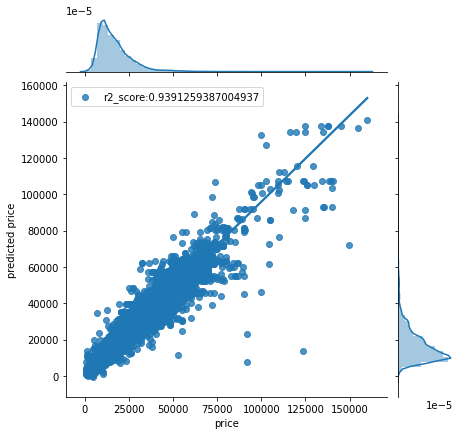

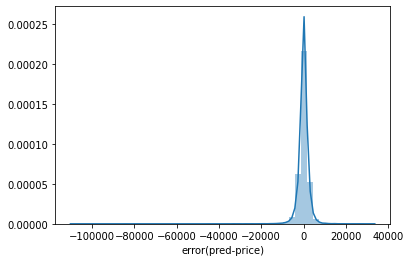

In [37]:
CarPrice_NN_base.plot_pred_price(features,y,retrain=False)

In [38]:
price_table = CarPrice_NN_base.price_diff(features,y)

In [39]:
price_table.head(25)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,...,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,price_diff_pct,price_diff_abs
20061,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1082.868226,1082.868226
39978,1,5,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1068.613957,1068.613957
11984,1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,937.161398,937.161398
71819,1,0,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,770.226045,770.226045
39711,1,2,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,700.114248,700.114248
69135,1,4,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,526.364511,526.364511
40171,1,4,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,500.428765,500.428765
44539,1,4,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,484.493075,484.493075
40172,1,2,1,2,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,392.906149,392.906149
39540,1,5,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,382.362596,382.362596


In [41]:
price_table.tail(25)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,...,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,price_diff_pct,price_diff_abs
31950,3,2,4,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.003973,0.003973
65933,4,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-0.003706,0.003706
48758,3,3,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,-0.003545,0.003545
21174,4,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.003404,0.003404
44193,2,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,-0.003181,0.003181
42856,2,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,-0.003181,0.003181
72946,3,3,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.002834,0.002834
76303,3,3,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.002834,0.002834
87518,4,1,4,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,-0.002014,0.002014
22719,4,2,4,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,-0.001612,0.001612


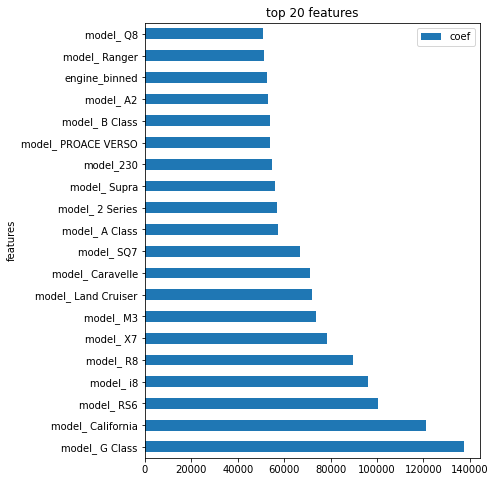

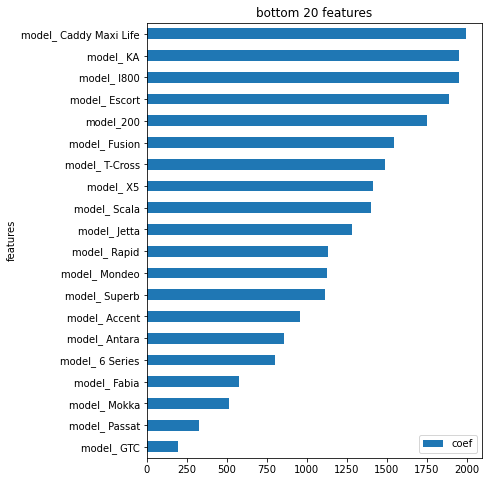

In [43]:
feature_table = CarPrice_NN_base.linear_feature_importance(features,plot=True)

### Pretty decent results and the error appear to be normal distribution

## Try a bigger model 

In [44]:
bigger_model = NNCarPrice.make_model([2056,2014,512,512],input_size,METRICS,1e-4,lr)

In [45]:
bigger_model.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2056)              452320    
_________________________________________________________________
dense_4 (Dense)              (None, 2014)              4142798   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1031680   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 5,889,967
Trainable params: 5,889,967
Non-trainable params: 0
_________________________________________________________________


In [46]:
CarPrice_NN_bigger = NNCarPrice(bigger_model,BATCH_SIZE,MAX_EPOCH,[EARLYSTOP])

In [53]:
CarPrice_NN_bigger.regression_metrics(X_train,y_train,"train",True,train_dataset,dev_dataset,V=0)

Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.943664,2337.372913,839.939602


In [54]:
CarPrice_NN_bigger.regression_metrics(X_test,y_test,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.937074,2419.736058,498.314002


In [55]:
bigger_model_tuned = CarPrice_NN_bigger._trained_model

In [56]:
NNCarPrice.save_model(bigger_model_tuned,"bigger_model_nn.h5")

In [57]:
bigger_model_tuned = NNCarPrice.load_model("bigger_model_nn.h5")

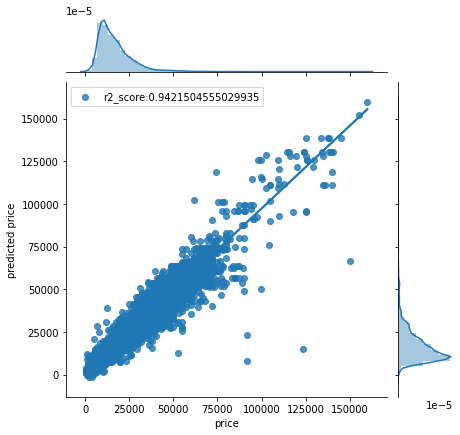

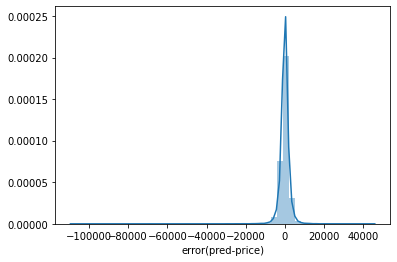

In [58]:
CarPrice_NN_bigger.plot_pred_price(features,y,retrain=False)

### Pretty decent result and not over training the train data either

In [59]:
bigger_model_2 = NNCarPrice.make_model([2056,2014,512,512],input_size,METRICS,1e-4,5e-5)

In [60]:
bigger_model_2.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2056)              452320    
_________________________________________________________________
dense_9 (Dense)              (None, 2014)              4142798   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1031680   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 5,889,967
Trainable params: 5,889,967
Non-trainable params: 0
_________________________________________________________________


In [61]:
CarPrice_NN_bigger_2 = NNCarPrice(bigger_model_2,BATCH_SIZE,MAX_EPOCH,[EARLYSTOP])

In [62]:
CarPrice_NN_bigger_2.regression_metrics(X_train,y_train,"train",True,train_dataset,dev_dataset,0)

Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.942323,2365.02331,800.008796


In [63]:
CarPrice_NN_bigger_2.regression_metrics(X_test,y_test,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.93771,2407.48296,674.227163


In [64]:
bigger_model_2 = CarPrice_NN_bigger_2._trained_model

In [65]:
NNCarPrice.save_model(bigger_model_2,"bigger_model_2.h5")

In [66]:
bigger_model_2 = NNCarPrice.load_model("bigger_model_2.h5")

In [67]:
CarPrice_NN_bigger_2.reset_trained_model(bigger_model_2)

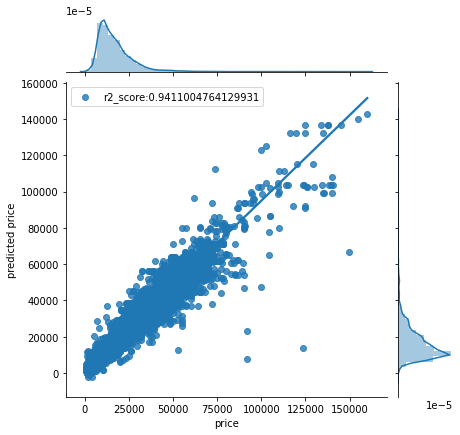

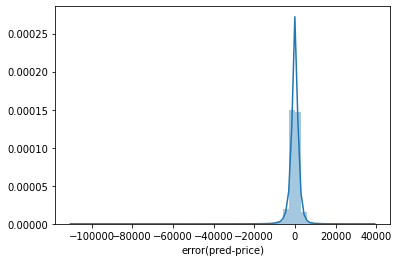

In [68]:
CarPrice_NN_bigger_2.plot_pred_price(features,y,False)

### Since we have limited data, having bigger NN didn't seem to help with the improvement

------

### Looking at special cases of why the model has hard time predicting certain car price

In [69]:
price_table_final = CarPrice_NN_bigger_2.price_diff(features,y)

In [70]:
price_table_final.head(20)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,...,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,price_diff_pct,price_diff_abs
11984,1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,800.008796,800.008796
39711,1,2,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,692.560161,692.560161
39978,1,5,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,674.227163,674.227163
71819,1,0,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,628.919030,628.919030
39540,1,5,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,409.017759,409.017759
69135,1,4,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,389.395074,389.395074
44539,1,4,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,375.946723,375.946723
20061,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,365.510506,365.510506
77582,1,4,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,362.585978,362.585978
40171,1,4,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,339.597059,339.597059


### Most of these models are older. The top cases have a weird combination of low car mileage but older year model 

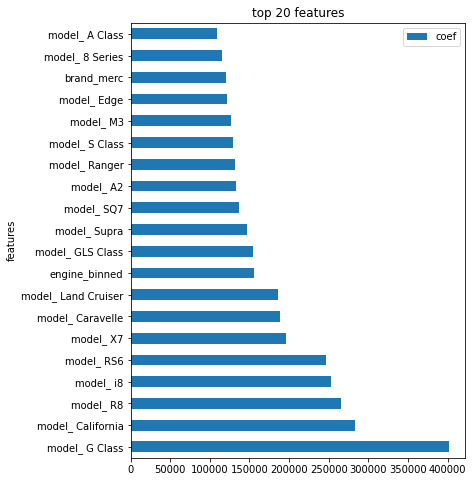

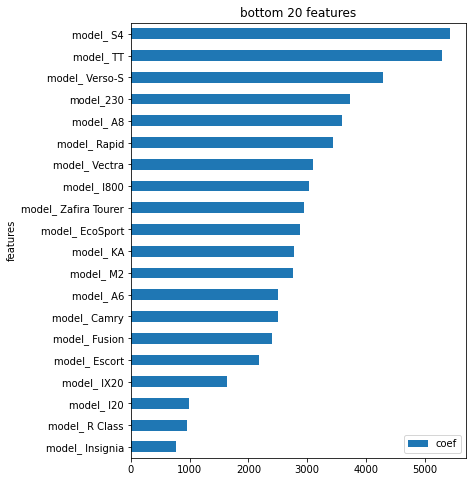

In [71]:
feature_table = CarPrice_NN_bigger_2.linear_feature_importance(features,plot=True)

### Let's tune learning rate

In [72]:
params = np.power(0.1,np.arange(0.5,7))

In [73]:
partial_model = partial(NNCarPrice.make_model,[2056,2014,512,512],input_size,METRICS,1e-4)

311/311 [==============================] - 1s 4ms/step - loss: 379819552.0000 - MAPE: 99.9988 - MAE: 16817.9414 - val_loss: 388380928.0000 - val_MAPE: 99.9971 - val_MAE: 16842.3145


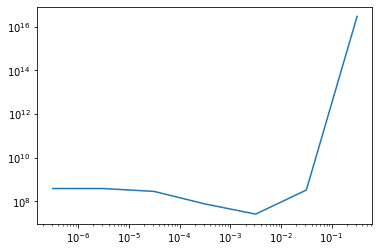

In [76]:
CarPrice_NN_bigger_2.param_search(params,partial_model,train_dataset,dev_dataset,1)

### appears learning rate between 10-2 and 10-3 would work great

In [77]:
params_2 = [0.05,0.025,0.01,0.005,0.0025,0.001,0.0005]

311/311 [==============================] - 1s 4ms/step - loss: 58581204.0000 - MAPE: 28.4174 - MAE: 4384.9927 - val_loss: 16315257.0000 - val_MAPE: 14.7430 - val_MAE: 2273.1748


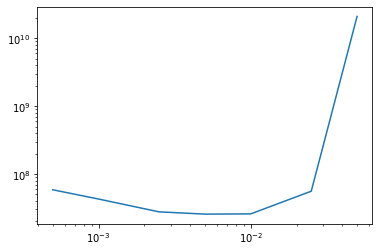

In [80]:
CarPrice_NN_bigger_2.param_search(params_2,partial_model,train_dataset,dev_dataset,1)

### It appears lr of 0.001 works the best which we already use

### The NN models have mostly car model type as top and bottom features


____